In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)
'''
For reproducable results
'''
tf.random.set_seed(41)
np.random.seed(41)

2.1.0


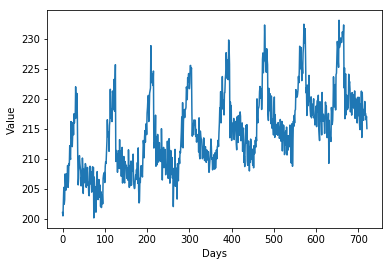

In [9]:
'''
This block of code generates the data we will need for training RNNs.
'''

def getTrend(time, slope=0):
    return slope * time

def getSeasonalPattern(season_time):
    """An arbitary seasonal pattern"""
    return np.where(season_time < 0.4,
                    np.sin(season_time * np.pi),
                    1 / np.exp(2 * season_time))

def addSeasonility(time, period, amplitude=1, phase=90):
    """Repeating pattern"""
    season_time = ((time + phase) % period) / period
    return amplitude * getSeasonalPattern(season_time)

def addNoise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

season_len = 90
time = np.arange(8 * season_len + 1, dtype="float32")
series = getTrend(time, 0.1)  
baseline = 200
amplitude = 20
slope = 0.02
noise_level = 2


# Create the series
series = baseline + getTrend(time, slope) + addSeasonility(time, period=season_len, amplitude=amplitude)
# Update with noise
series += addNoise(time, noise_level, seed=42)

plt.xlabel("Days")
plt.ylabel("Value")
plt.plot(series)


split = int(0.8 * len(series))
training_split= series[0:split]
test_split = series[split:]

In [10]:
'''
This block is just for visualization and given you an idea about what various lines in tensorflow.data do.
'''

def timeSeriesDataset(data_series, time_window_size):
  dataset = tf.data.Dataset.from_tensor_slices(data_series)
  dataset = dataset.window(time_window_size + 1, shift=1, drop_remainder=True)
  return dataset


'''
Lets visualize how our data looks like. With a window size of 5, first there elements of dataset look as follows.
Note that this is just for visualization. Our actual time_window_size is 30.
'''
fake_dataset = timeSeriesDataset(training_split, time_window_size=3)
count = 0
print("Printing random 3 rows when time window length is 3")
for win in fake_dataset:
    if count <3:
        for val in win:
            print(val.numpy(), end=" ") 
        print()
    count = count +1 
    
print("\nPrinting for windowed dataset random 3 rows when time window length is 3")
fake_dataset = fake_dataset.flat_map(lambda win: win.batch(3 + 1))

count = 0
for win in fake_dataset:
    if count <3: 
        print(win.numpy())
    count = count +1 
    
print("\n Rows in a dataset seperated by time series data and label")
fake_dataset = fake_dataset.shuffle(20).map(lambda win:(win[:-1], win[-1]))
count = 0
for win, lab in fake_dataset:
    if count <3: 
        print(win.numpy(), lab.numpy())
    count = count +1 
    
print("\n One batch in a batched dataset. First array is time series data and the second array is labels.")
fake_dataset = fake_dataset.batch(batch_size=2).prefetch(10)

for bat_data, bat_lab in fake_dataset.take(1):
    print(bat_data.numpy(), bat_lab.numpy())

Printing random 3 rows when time window length is 3
200.99342 200.44145 202.7305 205.19664 
200.44145 202.7305 205.19664 202.39516 
202.7305 205.19664 202.39516 203.10469 

Printing for windowed dataset random 3 rows when time window length is 3
[200.99342 200.44145 202.7305  205.19664]
[200.44145 202.7305  205.19664 202.39516]
[202.7305  205.19664 202.39516 203.10469]

 Rows in a dataset seperated by time series data and label
[209.17543 208.89273 212.15234] 210.29965
[202.7305  205.19664 202.39516] 203.10469
[208.85866 205.20087 206.2196 ] 209.17543

 One batch in a batched dataset. First array is time series data and the second array is labels.
[[208.89273 212.15234 210.29965]
 [216.18706 213.35106 214.46823]] [209.86864 211.9973 ]


In [15]:
time_window_size = 120  
shuffle_buffer = 500
batch_size = 32

def getTimeSeriesData(data_series, time_window_size, batch=False):
    dataset = tf.data.Dataset.from_tensor_slices(data_series)
    dataset = dataset.window(time_window_size + 1, shift=1, drop_remainder=True) 
    '''
    Lets create a dataset where in each row is a coherent time-series window.
    '''

    dataset = dataset.flat_map(lambda win: win.batch(time_window_size + 1))

    '''
    As we know, our last data-point is the future prediction. So, lets separate it!
    additionally lets shuffle the dataset.
    '''

    dataset = dataset.shuffle(shuffle_buffer).map(lambda win:(win[:-1], win[-1]))
    '''
    Lets create a batched dataset!
    '''
    if batch:
        dataset = dataset.batch(batch_size).prefetch(10)
    return dataset

training_dataset = getTimeSeriesData(training_split, time_window_size=time_window_size, batch=True)

In [23]:
'''
Clear model of earlier versions.
'''
tf.keras.backend.clear_session()
'''
Create model
'''

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), ## RNN need extra dimesion of the data
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(64, return_sequences=True),
  tf.keras.layers.SimpleRNN(64),
  tf.keras.layers.Dense(1),])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda ep: 1e-7 * 10**(ep / 15))
optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.90)
model.compile(loss=tf.keras.losses.mae,
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(training_dataset, epochs=90, callbacks=[lr_schedule])

Epoch 1/90
15/15 [==============================] - 1s 74ms/step - loss: 215.0026 - mae: 214.8447
Epoch 2/90
15/15 [==============================] - 1s 35ms/step - loss: 214.9240 - mae: 214.8286
Epoch 3/90
15/15 [==============================] - 1s 34ms/step - loss: 215.0422 - mae: 214.8028
Epoch 4/90
15/15 [==============================] - 1s 35ms/step - loss: 214.8217 - mae: 214.7672
Epoch 5/90
15/15 [==============================] - 1s 36ms/step - loss: 214.7847 - mae: 214.7216
Epoch 6/90
15/15 [==============================] - 1s 34ms/step - loss: 214.6259 - mae: 214.6730
Epoch 7/90
15/15 [==============================] - 1s 36ms/step - loss: 214.6242 - mae: 214.6333
Epoch 8/90
15/15 [==============================] - 1s 36ms/step - loss: 214.6148 - mae: 214.6050
Epoch 9/90
15/15 [==============================] - 1s 35ms/step - loss: 214.5485 - mae: 214.5837
Epoch 10/90
15/15 [==============================] - 0s 32ms/step - loss: 214.4727 - mae: 214.5658
Epoch 11/90
15/15 [

15/15 [==============================] - 1s 34ms/step - loss: 4.8916 - mae: 4.9466
Epoch 85/90
15/15 [==============================] - 1s 34ms/step - loss: 4.8559 - mae: 4.8771
Epoch 86/90
15/15 [==============================] - 0s 33ms/step - loss: 4.8110 - mae: 4.9333
Epoch 87/90
15/15 [==============================] - 1s 34ms/step - loss: 5.3141 - mae: 5.2905
Epoch 88/90
15/15 [==============================] - 0s 33ms/step - loss: 5.0530 - mae: 5.0441
Epoch 89/90
15/15 [==============================] - 1s 34ms/step - loss: 4.8620 - mae: 4.8464
Epoch 90/90
15/15 [==============================] - 0s 32ms/step - loss: 4.8860 - mae: 4.9019


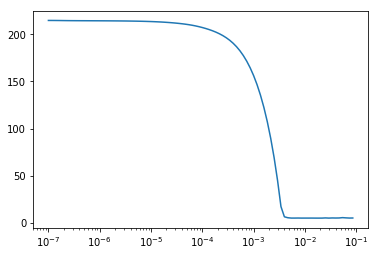

In [26]:
plt.semilogx(history.history["lr"], history.history["loss"])

In [27]:
'''
Clear model of earlier versions.
'''
tf.keras.backend.clear_session()
'''
Create model with the learning rate from the plot above.
'''

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), ## RNN need extra dimesion of the data
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(64, return_sequences=True),
  tf.keras.layers.SimpleRNN(64),
  tf.keras.layers.Dense(1),])

optimizer = tf.keras.optimizers.SGD(lr=5e-3, momentum=0.90)
model.compile(loss=tf.keras.losses.mae,
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(training_dataset, epochs=90, callbacks=[lr_schedule])

Epoch 1/90
15/15 [==============================] - 1s 76ms/step - loss: 214.4172 - mae: 214.5288
Epoch 2/90
15/15 [==============================] - 1s 34ms/step - loss: 214.5336 - mae: 214.5269
Epoch 3/90
15/15 [==============================] - 0s 33ms/step - loss: 214.5148 - mae: 214.5243
Epoch 4/90
15/15 [==============================] - 0s 32ms/step - loss: 214.3533 - mae: 214.5211
Epoch 5/90
15/15 [==============================] - 1s 34ms/step - loss: 214.5201 - mae: 214.5173
Epoch 6/90
15/15 [==============================] - 1s 35ms/step - loss: 214.4214 - mae: 214.5129
Epoch 7/90
15/15 [==============================] - 1s 34ms/step - loss: 214.7214 - mae: 214.5078
Epoch 8/90
15/15 [==============================] - 1s 34ms/step - loss: 214.3824 - mae: 214.5018
Epoch 9/90
15/15 [==============================] - 1s 34ms/step - loss: 214.4198 - mae: 214.4949
Epoch 10/90
15/15 [==============================] - 0s 33ms/step - loss: 214.6598 - mae: 214.4868
Epoch 11/90
15/15 [

15/15 [==============================] - 0s 33ms/step - loss: 5.1917 - mae: 5.1265
Epoch 85/90
15/15 [==============================] - 0s 33ms/step - loss: 5.2904 - mae: 5.2422
Epoch 86/90
15/15 [==============================] - 0s 33ms/step - loss: 5.1736 - mae: 5.0849
Epoch 87/90
15/15 [==============================] - 1s 34ms/step - loss: 5.1661 - mae: 5.1353
Epoch 88/90
15/15 [==============================] - 0s 30ms/step - loss: 5.9899 - mae: 6.0179
Epoch 89/90
15/15 [==============================] - 0s 32ms/step - loss: 5.3251 - mae: 5.2493
Epoch 90/90
15/15 [==============================] - 0s 31ms/step - loss: 4.9599 - mae: 4.9906


In [28]:
'''
Lets check how this model performs on our test dataset
'''

model_forcast = []

for t in range(len(test_split) - time_window_size):
    model_forcast.append(model.predict(test_split[t:t + time_window_size][np.newaxis]))

model_forcast = np.array(model_forcast)
true_forcast = np.array(test_split[time_window_size:])



In [29]:
test_loss = tf.keras.losses.MAE(
    true_forcast, model_forcast
).numpy()

test_loss = np.mean(loss)

print("Mean absolute error on test set is:", test_loss)


NameError: name 'loss' is not defined

In [ ]:
'''
Plot accuracy vs Number of epocha
'''

mae=history.history['mae']
loss=history.history['loss']
epochs=range(len(loss)) # Get number of epochs
plt.plot(epochs, mae)
plt.title('MAE')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE"])

plt.figure()